In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from csi.pipeline import kernels
import librosa
from librosa import display
from csi.vendor import simplefast
from csi.pipeline import ssm as ssmlib
import IPython.display as ipd
audio_file = '/dataset/YTCdataset/jbg/v1.mp3'
#audio_file = '/dataset/mazurkas/mazurka06-4/pid9049-04.mp3'
y, sr = librosa.load(audio_file)
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
seconds = len(y)/sr
samples_per_beat = (60 * sr) / tempo

/usr/local/lib/python3.5/dist-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [4]:
tempo

83.35433467741936

In [87]:
def samples_per_beat(feature):
    feature_sr = len(feature[0])/seconds
    return (60 * feature_sr) / tempo

def normalize(x):
    arr = np.array(x)
    arr2 = arr - arr.min()
    return (arr2/np.amax(arr2))



In [88]:
# buscar um hop_length de modo que o chroma não seja mto grande - ~1500 frames roda rápido
chroma_orig = librosa.feature.chroma_cens(y, sr, hop_length=2**11)
#beat_f = librosa.util.fix_frames(beats, x_max=chroma_orig.shape[1])
#sync = librosa.util.sync(chroma_orig, beat_f, aggregate=np.median)
chroma_spb = samples_per_beat(chroma_orig)
chroma = chroma_orig
#chroma = np.array(chroma_orig).T[309:381].T
chroma_length = len(chroma[0])

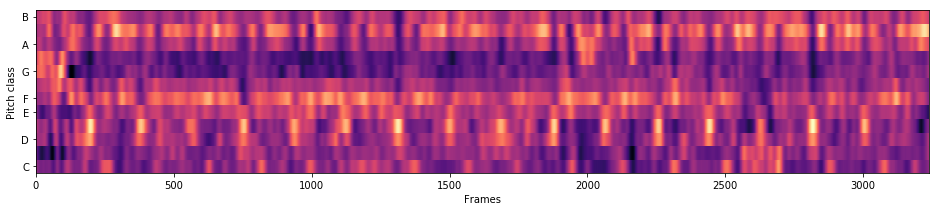

In [89]:
plt.figure(figsize=(16, 3))
display.specshow(chroma, **{'y_axis':'chroma', 'x_axis':'frames'})
plt.show()

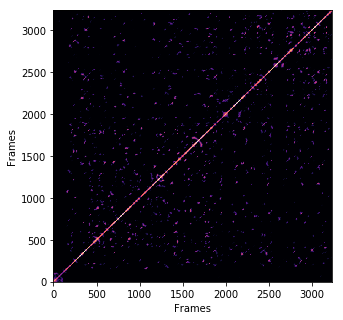

In [90]:
ssm = librosa.segment.recurrence_matrix(chroma, width=1, mode='affinity', sym=True, self=True)
ssm = librosa.segment.path_enhance(ssm, 20, window='hann', n_filters=5)
plt.figure(figsize=(5, 5))
display.specshow(ssm, **{'y_axis':'frames', 'x_axis':'frames'})
plt.show()

In [91]:
multiplier = 64
m_size = int(multiplier * chroma_spb)
kernel = kernels.kernel_checkerboard_gaussian(m_size)
chroma_length = len(chroma[0])
profile = normalize(ssmlib.compute_novelty_profile(ssm, kernel))
peaks = scipy.signal.find_peaks(profile, **{'height': 0.2 , 'distance': m_size })[0]

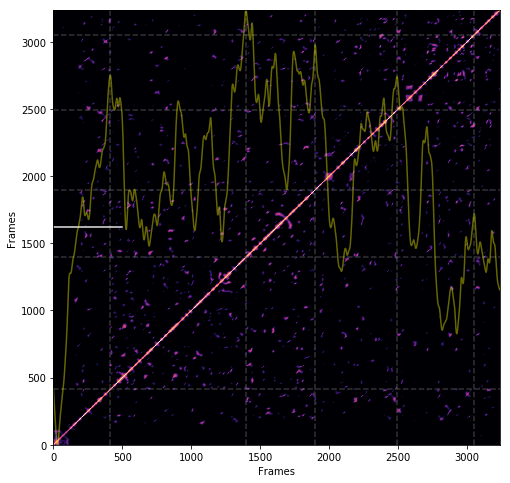

In [92]:
m_line = np.zeros(m_size) + chroma_length/2
plt.figure(figsize=(8, 8))
display.specshow(ssm, **{'y_axis':'frames', 'x_axis':'frames'})

plt.plot(m_line, color='white', alpha=0.9)

plt.plot(profile * len(ssm[0]), color='yellow', alpha=0.4)

plt.vlines(peaks, 0, chroma_length, color='gray', alpha=0.4, linestyle='--', label='Onsets')
plt.hlines(peaks, 0, chroma_length, color='gray', alpha=0.4, linestyle='--', label='Onsets')
plt.show()

In [93]:
peaks

array([ 412, 1395, 1899, 2492, 3052])

In [94]:
ssm2 = ssm[peaks[1]:peaks[2], peaks[1]:peaks[2]]
multiplier2 = 32
m_size2 = int(multiplier2 * chroma_spb)
kernel2 = kernels.kernel_checkerboard_gaussian(m_size2)
chroma_length2 = len(ssm2[0])
profile2 = normalize(ssmlib.compute_novelty_profile(ssm2, kernel2))
peaks2 = scipy.signal.find_peaks(profile2, **{'height': 0.2 , 'distance': m_size2 })[0]

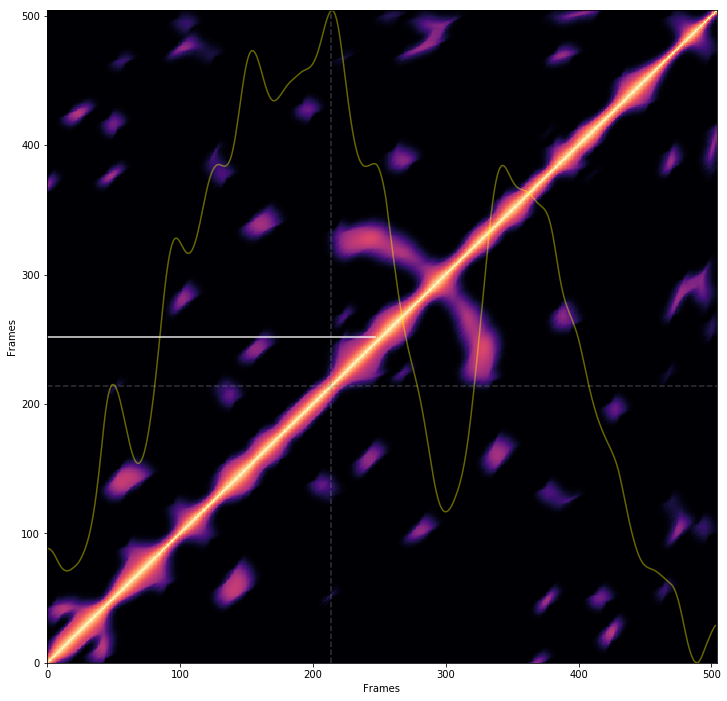

In [95]:
m_line2 = np.zeros(m_size2) + chroma_length2/2
plt.figure(figsize=(12, 12))
display.specshow(ssm2, **{'y_axis':'frames', 'x_axis':'frames'})

plt.plot(m_line2, color='white', alpha=0.9)
plt.plot(profile2 * len(ssm2[0]), color='yellow', alpha=0.4)

plt.vlines(peaks2, 0, chroma_length2, color='gray', alpha=0.4, linestyle='--', label='Onsets')
plt.hlines(peaks2, 0, chroma_length2, color='gray', alpha=0.4, linestyle='--', label='Onsets')
plt.show()

In [96]:
from collections import defaultdict
class ProfileSegment:
    peaks = None
    def __init__(self, ssm, pos_ini, pos_end, k_size, max_levels=999, uid='0', level=1):        
        if k_size < 2 or max_levels==0:
            return
        if (pos_end - pos_ini) < (k_size * 2):
            return
        self.uid = uid
        self.level = level
        self.max_levels = max_levels
        self.pos_ini = int(pos_ini)
        self.pos_end = int(pos_end)
        self.ssm = ssm
        self.k_size = k_size
        self.segments = []
        self.compute()
        
    def list_peaks(self):
        l = self._get_peaks_rec(defaultdict(list))
        arr = []
        for key in np.sort([int(k) for k in l.keys()]):
            elements = np.unique(l[str(key)])
            arr.append(elements)
        return arr
        
    def get_points(self):
        return np.sort(np.append(self.peaks, [self.pos_ini, self.pos_end]))
    
    
    def ssm_block(self):
        return self.ssm[self.pos_ini:(self.pos_end -1)]
    
    def compute(self):
        self.compute_peaks()
        self.compute_segments()
    
    def plot(self):
        plt.vlines(self.peaks, self.pos_ini, self.pos_end, color='white', alpha=0.4, linestyle='--', label='Onsets')
        plt.hlines(self.peaks, self.pos_ini, self.pos_end, color='white', alpha=0.4, linestyle='--', label='Onsets')
        for s in self.segments:
            s.plot()
    
    def compute_peaks(self):
        kernel = kernels.kernel_checkerboard_gaussian(int(self.k_size))
        profile = normalize(ssmlib.compute_novelty_profile(self.ssm_block(), kernel))
        self.peaks = scipy.signal.find_peaks(profile, **{'height': 0.05 , 'distance': self.k_size })[0]
        self.peaks += self.pos_ini
    
    def compute_segments(self):
        points = self.get_points()
        idx=-1
        self.segments = []
        for i in zip(points, points[1:]):            
            idx+=1
            pos_ini, pos_end = i
            segment = ProfileSegment(self.ssm, pos_ini, pos_end, int(self.k_size/2), self.max_levels -1, self.uid + '.' + str(idx), self.level+1)
            if segment.peaks is not None:
                self.segments.append(segment)
    
    def _get_peaks_rec(self, peak_dict):
        for p in self.get_points():
            peak_dict[str(self.level)].append(p)
        for s in self.segments:
            s._get_peaks_rec(peak_dict)
        if self.level==1:
            return dict(peak_dict)


In [99]:
k_size = int(128 * chroma_spb)
prf = ProfileSegment(ssm, 0, len(ssm[0]), k_size, max_levels=6)



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


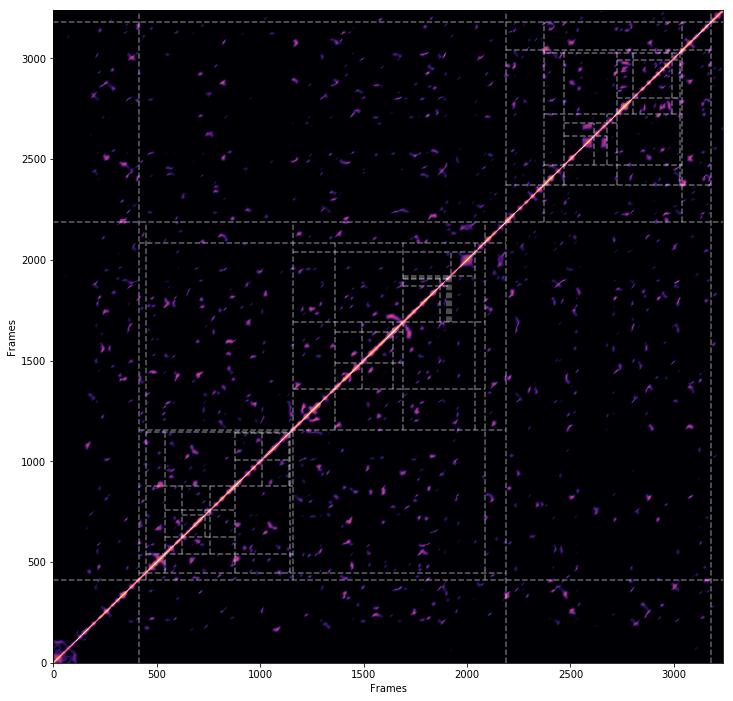

In [100]:
plt.figure(figsize=(12, 12))
display.specshow(ssm, **{'y_axis':'frames', 'x_axis':'frames'})
plt.plot(k_size, color='white', alpha=0.9)
#plt.plot(profile * len(ssm[0]), color='yellow', alpha=0.4)
prf.plot()
plt.show()

In [101]:
pks = prf.list_peaks()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


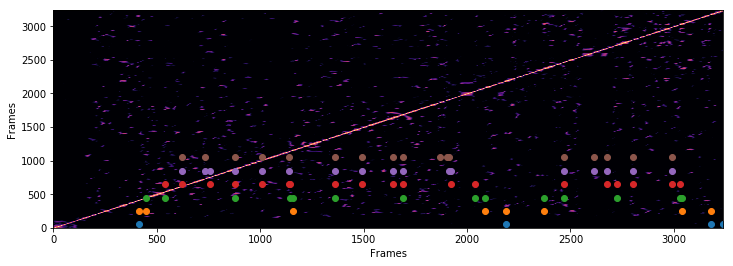

In [102]:
pks
plt.figure(figsize=(12, 4))
display.specshow(ssm, **{'y_axis':'frames', 'x_axis':'frames', 'alpha':0.5})
bin_size = len(ssm[0])/len(pks)
bin_size
for idx in range(len(pks)):
    #plt.vlines(pks[idx], idx*bin_size, idx*bin_size+bin_size, color='white', alpha=0.8, linestyle='-', label='Onsets')
    plt.plot(pks[idx], pks[idx]/pks[idx] + idx*200+50, 'o')
#plt.plot(k_size, color='white', alpha=0.9)
#plt.plot(profile * len(ssm[0]), color='yellow', alpha=0.4)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


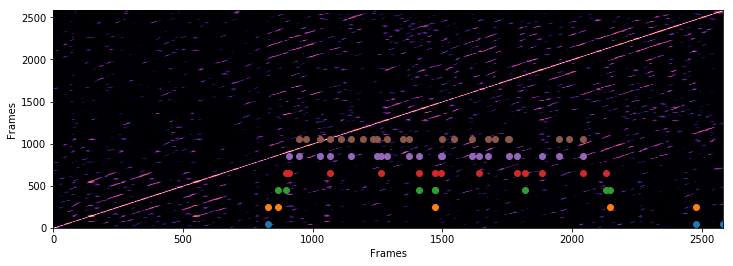

In [61]:
pks
plt.figure(figsize=(12, 4))
display.specshow(ssm, **{'y_axis':'frames', 'x_axis':'frames', 'alpha':0.5})
bin_size = len(ssm[0])/len(pks)
bin_size
for idx in range(len(pks)):
    #plt.vlines(pks[idx], idx*bin_size, idx*bin_size+bin_size, color='white', alpha=0.8, linestyle='-', label='Onsets')
    plt.plot(pks[idx], pks[idx]/pks[idx] + idx*200+50, 'o')
#plt.plot(k_size, color='white', alpha=0.9)
#plt.plot(profile * len(ssm[0]), color='yellow', alpha=0.4)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


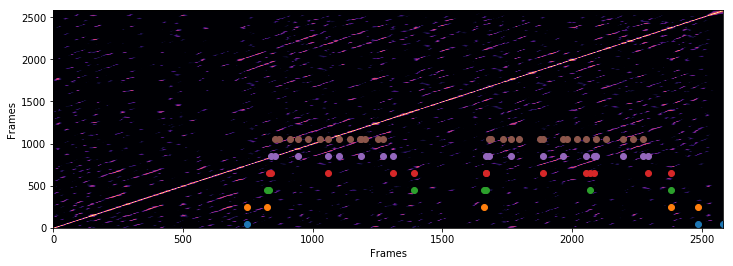

In [16]:
pks
plt.figure(figsize=(12, 4))
display.specshow(ssm, **{'y_axis':'frames', 'x_axis':'frames', 'alpha':0.5})
bin_size = len(ssm[0])/len(pks)
bin_size
for idx in range(len(pks)):
    #plt.vlines(pks[idx], idx*bin_size, idx*bin_size+bin_size, color='white', alpha=0.8, linestyle='-', label='Onsets')
    plt.plot(pks[idx], pks[idx]/pks[idx] + idx*200+50, 'o')
#plt.plot(k_size, color='white', alpha=0.9)
#plt.plot(profile * len(ssm[0]), color='yellow', alpha=0.4)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


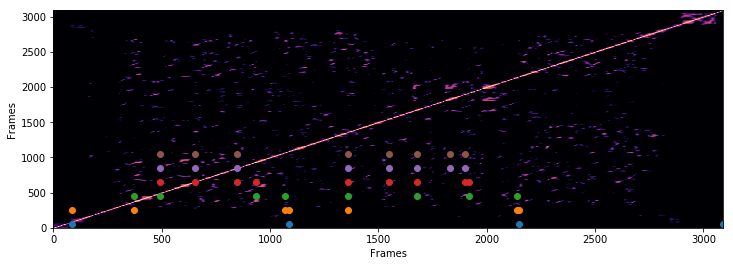

In [46]:
# JBG
pks
plt.figure(figsize=(12, 4))
display.specshow(ssm, **{'y_axis':'frames', 'x_axis':'frames', 'alpha':0.5})
bin_size = len(ssm[0])/len(pks)
bin_size
for idx in range(len(pks)):
    #plt.vlines(pks[idx], idx*bin_size, idx*bin_size+bin_size, color='white', alpha=0.8, linestyle='-', label='Onsets')
    plt.plot(pks[idx], pks[idx]/pks[idx] + idx*200+50, 'o')
#plt.plot(k_size, color='white', alpha=0.9)
#plt.plot(profile * len(ssm[0]), color='yellow', alpha=0.4)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


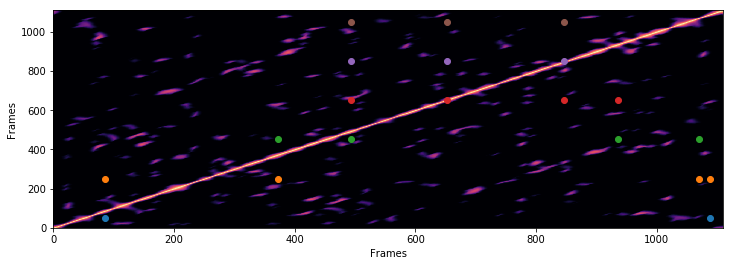

In [70]:
pks
plt.figure(figsize=(12, 4))
display.specshow(ssm, **{'y_axis':'frames', 'x_axis':'frames', 'alpha':0.5})
bin_size = len(ssm[0])/len(pks)
bin_size
for idx in range(len(pks)):
    #plt.vlines(pks[idx], idx*bin_size, idx*bin_size+bin_size, color='white', alpha=0.8, linestyle='-', label='Onsets')
    plt.plot(pks[idx], pks[idx]/pks[idx] + idx*200+50, 'o')
#plt.plot(k_size, color='white', alpha=0.9)
#plt.plot(profile * len(ssm[0]), color='yellow', alpha=0.4)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


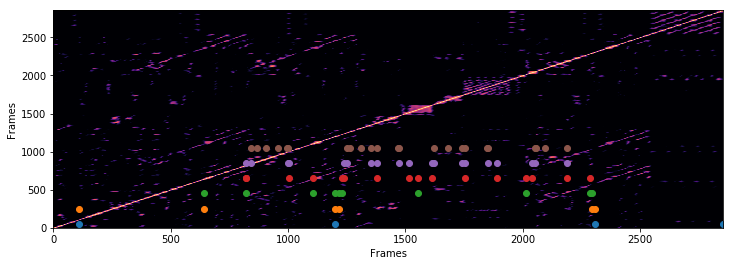

In [85]:
pks
plt.figure(figsize=(12, 4))
display.specshow(ssm, **{'y_axis':'frames', 'x_axis':'frames', 'alpha':0.5})
bin_size = len(ssm[0])/len(pks)
bin_size
for idx in range(len(pks)):
    #plt.vlines(pks[idx], idx*bin_size, idx*bin_size+bin_size, color='white', alpha=0.8, linestyle='-', label='Onsets')
    plt.plot(pks[idx], pks[idx]/pks[idx] + idx*200+50, 'o')
#plt.plot(k_size, color='white', alpha=0.9)
#plt.plot(profile * len(ssm[0]), color='yellow', alpha=0.4)
plt.show()